<a href="https://colab.research.google.com/github/Dkepffl/2022-2-ESAA/blob/main/Session/Session221205_cnn_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [49]:
!pip install keras.preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import numpy as np
import pandas as pd 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

## **Define Constants**

In [52]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## **Prepare Traning Data**

In [53]:
filenames = os.listdir("/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [54]:
df.head()

,filename,category
0,dog.8412.jpg,1
1,dog.8414.jpg,1
2,dog.8415.jpg,1
3,dog.8418.jpg,1
4,dog.8416.jpg,1


In [55]:
df.tail()

,filename,category
24993,dog.9846.jpg,1
24994,dog.9849.jpg,1
24995,dog.9855.jpg,1
24996,dog.11587.jpg,1
24997,dog.1158.jpg,1


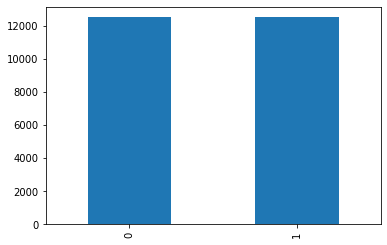

In [56]:
df['category'].value_counts().plot.bar()

## **See sample image**

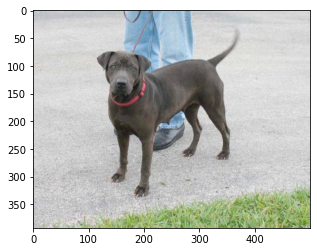

In [57]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/train/"+sample)
plt.imshow(image)

## **Build Model**

In [58]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

## **Callbacks**

In [59]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#### | **Early Stop**

In [60]:
earlystop = EarlyStopping(patience=10)

#### | **Learning Rate Reduction**

In [61]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [62]:
callbacks = [earlystop, learning_rate_reduction]

## **Prepare data**

In [63]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [64]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

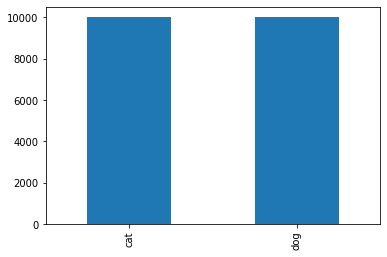

In [65]:
train_df['category'].value_counts().plot.bar()

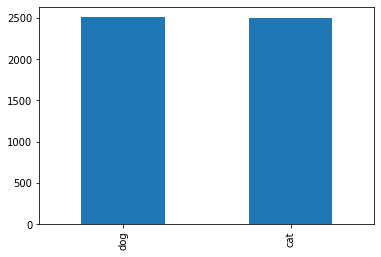

In [66]:
validate_df['category'].value_counts().plot.bar()

In [67]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## **Traning Generator**

In [68]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19998 validated image filenames belonging to 2 classes.


#### **Validation Generator**

In [69]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## **See how our generator work**

In [70]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


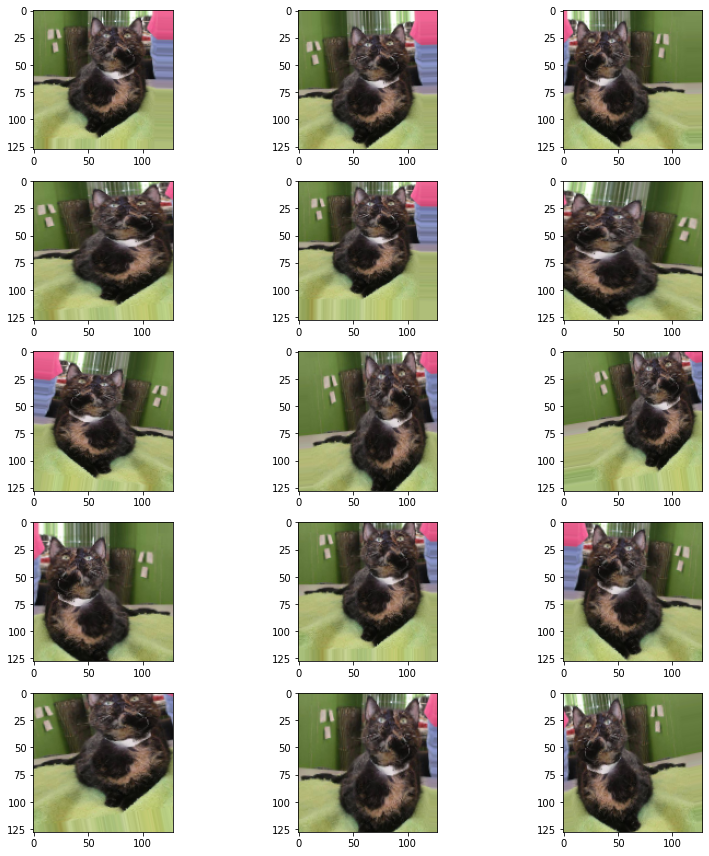

In [71]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## **Fit Model**

In [72]:
batch_size = 100

In [73]:
epochs=1
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-73-ed2ef0182076>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


199/199 [==============================] - ETA: 0s - loss: 1.2052 - accuracy: 0.5518

199/199 [==============================] - 1126s 6s/step - loss: 1.2052 - accuracy: 0.5518 - val_loss: 2.8471 - val_accuracy: 0.4973 - lr: 0.0010


## **Save Model**

In [74]:
model.save_weights("model.h5")

## **Virtualize Training**

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## **Prepare Testing Data**

In [77]:
test_filenames = os.listdir("/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## **Create Testing Generator**

In [79]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## **Predict**

In [80]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-80-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [81]:
test_df['category'] = np.argmax(predict, axis=-1)

In [82]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [85]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

#### | **Virtaulize Result**

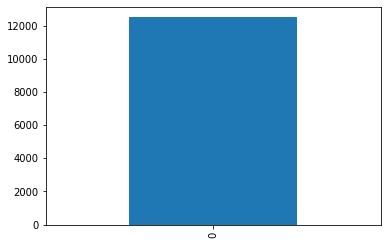

In [86]:
test_df['category'].value_counts().plot.bar()

#### | **See predicted result with images**

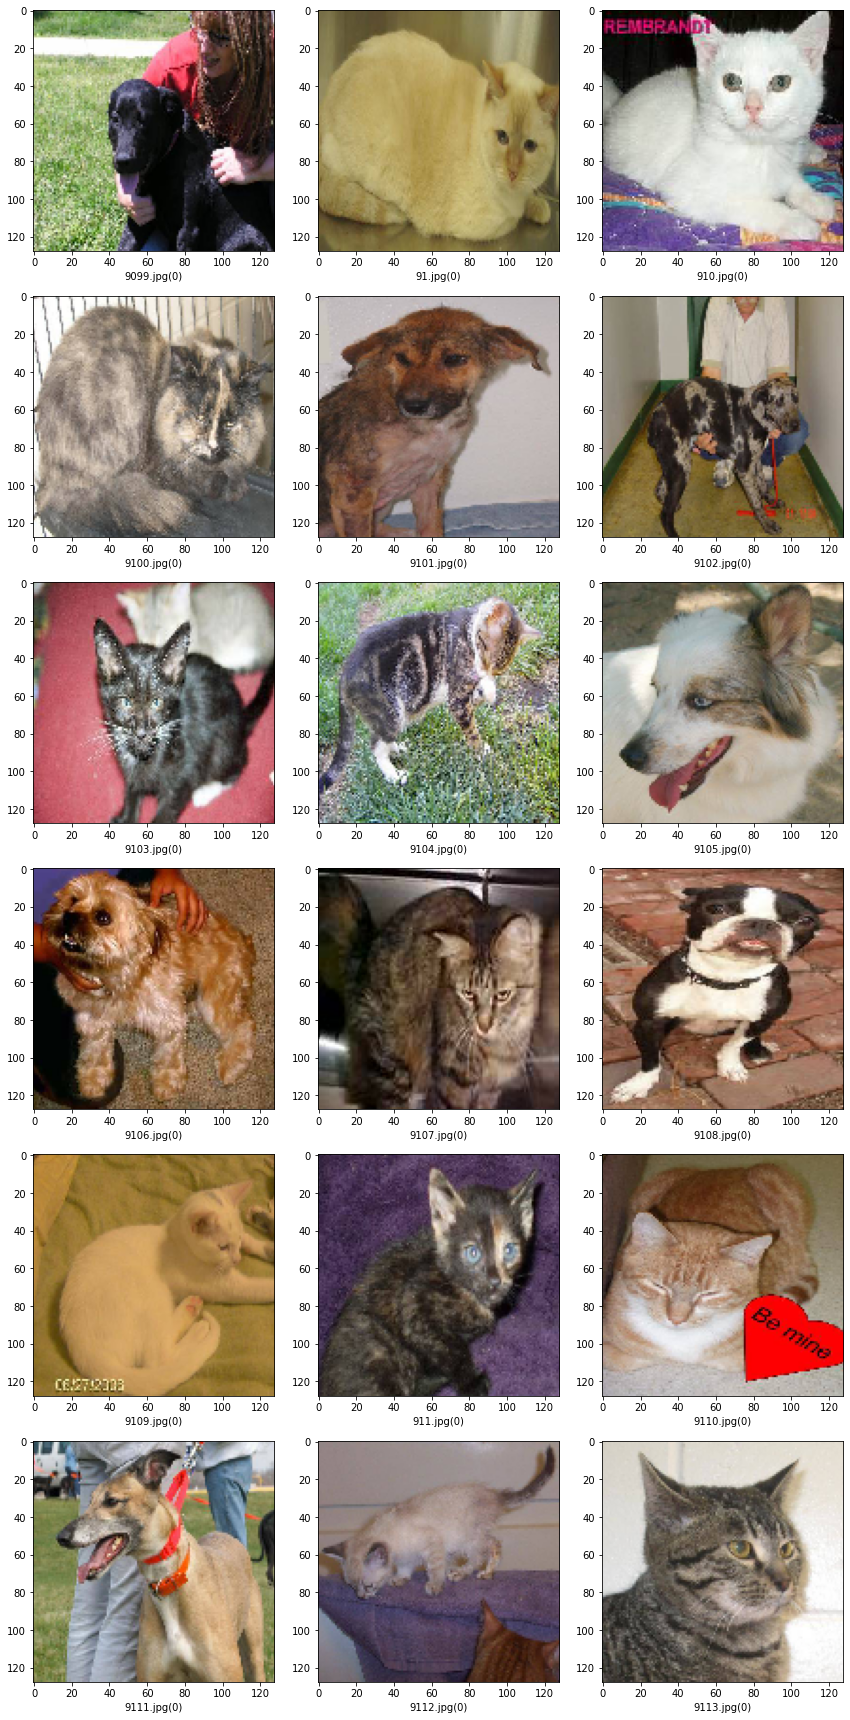

In [88]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/ESAA 7기 운영 자료/OB 캐글 실습 필사 데이터 및 연습 문제/캐글 실습 필사 데이터/dogs-vs-cats(원본 압축해제)/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()